In [1]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
results_path = "../results/burgers_dgsem_1D_test/";

In [2]:
A = 1.0  # amplitude
L = 1.0  # domain length
k = 2*π/L  # wave number
T = 0.1  # end time
initial_data = InitialDataSine(A,k)
conservation_law = burgers_equation();

In [3]:
M = 10  # number of elements
p = 2  # degree of discretization

reference_approximation = ReferenceApproximation(
    DGSEM(p), Line(), N_plot=20)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
form = StrongConservationForm()
strategy = Lazy()
solver = Solver(conservation_law, spatial_discretization, form, strategy)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true);

In [4]:
n_s = 10
dt_scale = 0.1
dt = dt_scale*(L/M)/(1.0*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");
plotter = Plotter(spatial_discretization, results_path)
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

save_solution(last(sol.u), last(sol.t), results_path, "final");

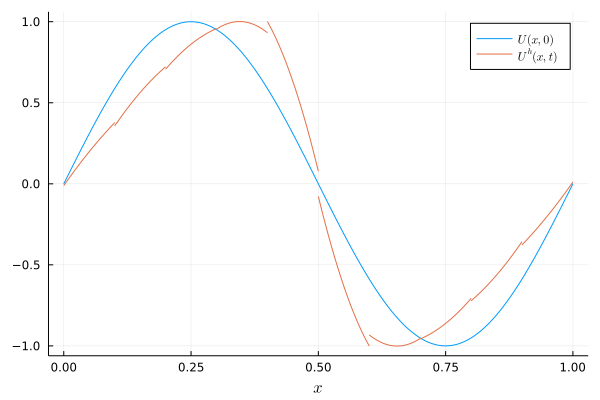

In [5]:
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,0)")

In [6]:
u_el = last(sol.u)[:,:,1]

3×1 Matrix{Float64}:
 -0.011158917401545107
  0.19813487952244646
  0.3771934674415302

In [7]:
F_sc = two_point_flux(conservation_law.two_point_flux, u_el)[1]

3×3 Matrix{Float64}:
 6.22607e-5  0.00619516  0.0230317
 0.00619516  0.0196287   0.0427113
 0.0230317   0.0427113   0.0711375

In [8]:
F_c = two_point_flux(ConservativeFlux{BurgersFlux{1}}(), u_el)[1]

3×3 Matrix{Float64}:
 6.22607e-5  0.00984549  0.0355999
 0.00984549  0.0196287   0.0453831
 0.0355999   0.0453831   0.0711375

In [9]:
F_c = [0.25*(u_el[i]^2 + u_el[j]^2) for i in 1:(p+1), j in 1:(p+1)]

3×3 Matrix{Float64}:
 6.22607e-5  0.00984549  0.0355999
 0.00984549  0.0196287   0.0453831
 0.0355999   0.0453831   0.0711375